# Setup

## import libraries and modules

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import permutations
from pandas_profiling import ProfileReport
import sweetviz as sv
from matplotlib_venn import venn3
import warnings
import numpy as np
from pathlib import Path
import cv2
from collections import Counter
import seaborn as sns
warnings.filterwarnings("ignore")
%matplotlib inline

## set constants

In [166]:
TRAIN = 'train.csv'
RANDOM_STATE = 42 
CASE = 'StudyInstanceUID'
TRAIN_IMG_REL_DIR = 'train'
CATHETERS = ['CVC', 'ETT' , 'NGT', 'Swan Ganz Catheter Present']

np.random.seed(RANDOM_STATE)

In [165]:
'catheters'.upper()

'CATHETERS'

## functions

In [180]:
def make_sets3(data: pd.DataFrame, *cols):
    group_a, group_b, group_c = cols
    group_a_ser, group_b_ser, group_c_ser =  data[group_a], data[group_b], data[group_c]
    a, b, c = (group_a_ser==1), (group_b_ser==1), (group_c_ser==1)
    a_only, b_only, c_only = (a & ~b & ~c), (~a & b & ~c), (~a & ~b & c)
    ab_only, ac_only, bc_only = (a & b & ~c), (a & ~b & c), (~a & b & c)
    abc = a & b & c
    return tuple(np.sum(group) for group in (a_only, b_only, ab_only, c_only, ac_only, bc_only, abc))

def get_img(cond, ax, data: pd.DataFrame, title: str=''):
    img_path = str(Path(TRAIN_IMG_REL_DIR) / np.random.choice(data[cond][CASE].values)) + '.jpg'
    img = cv2.imread(str(img_path), cv2.COLOR_BGR2GRAY)
    ax.imshow(img, cmap='gray')
    ax.set_title(title)

## read training set to file

In [101]:
df = pd.read_csv(TRAIN)

# EDA over labels

## Profiling with of the shelf packages

### pandas profiling

In [102]:
profile = ProfileReport(df)
profile

### sweetviz


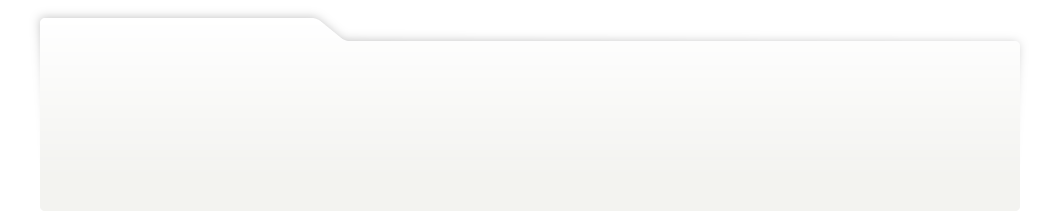
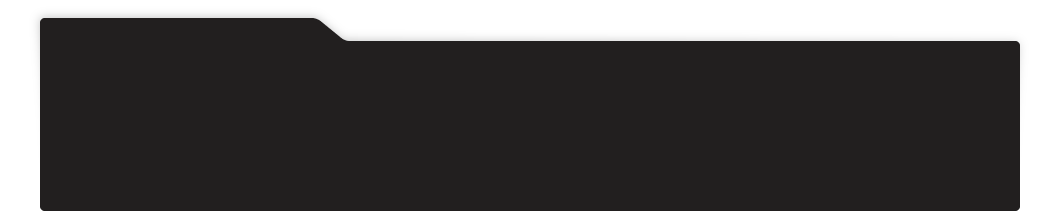
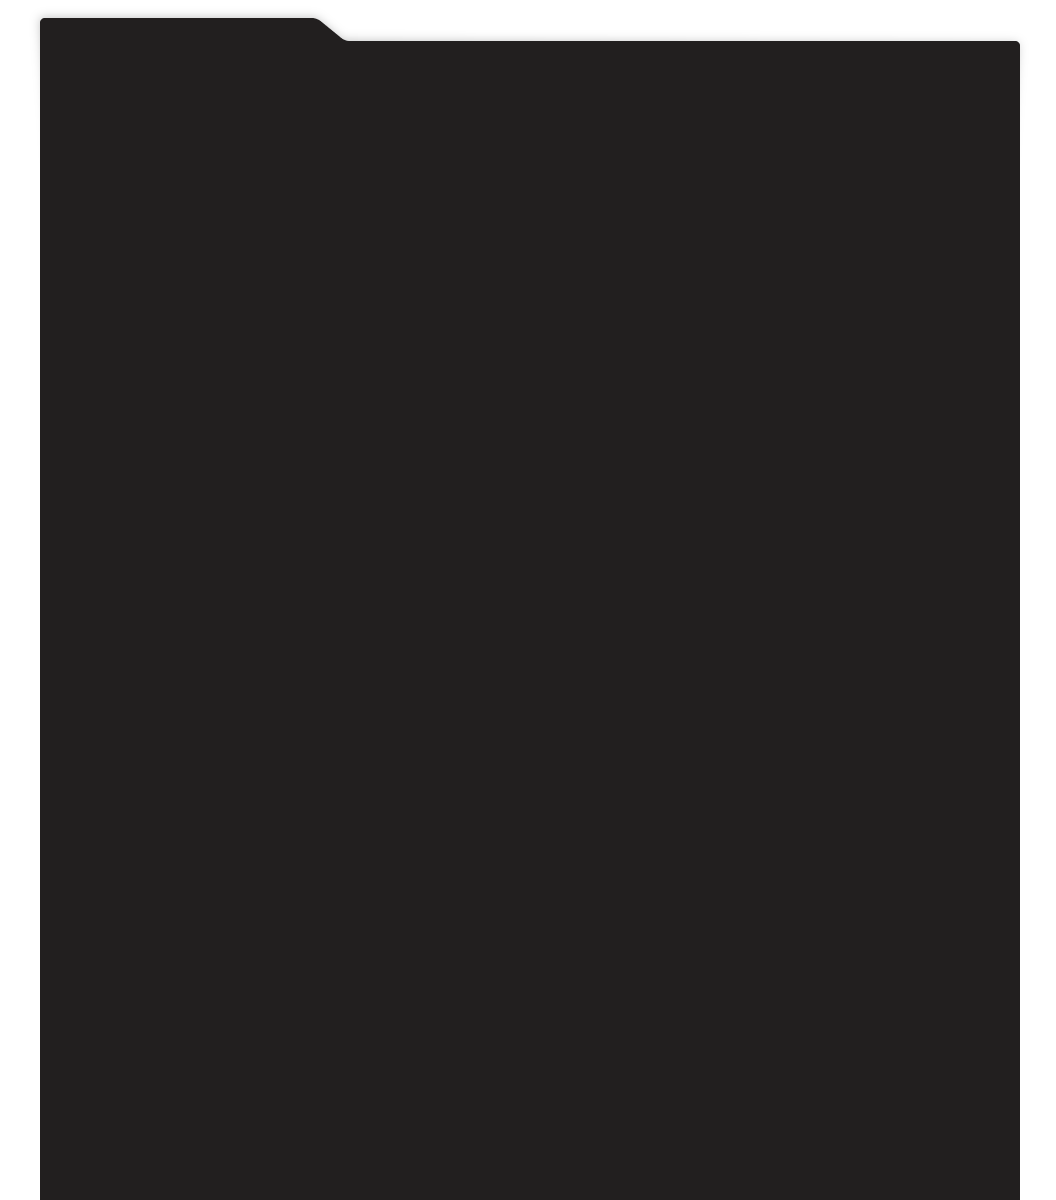
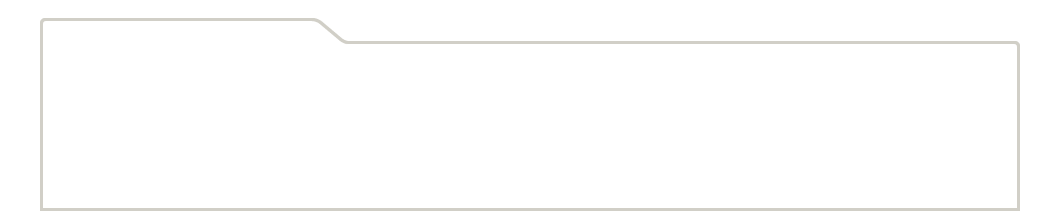
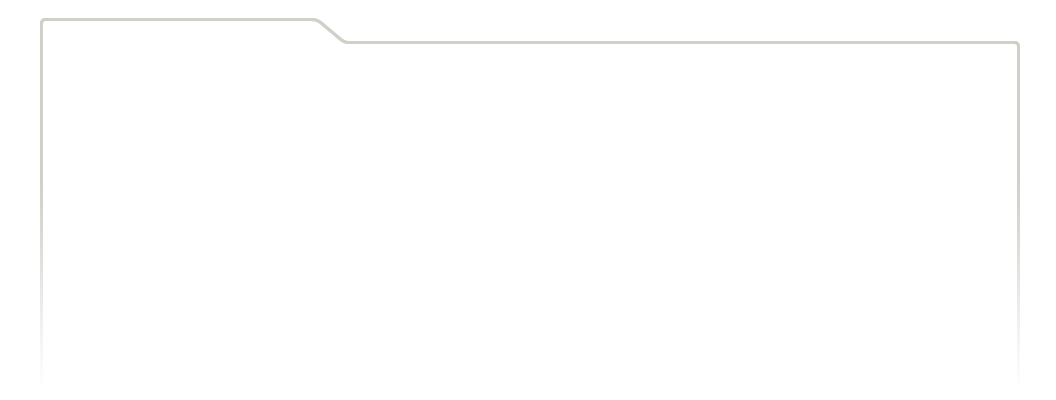
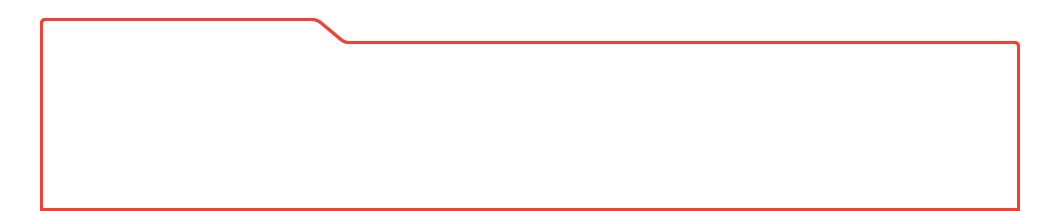
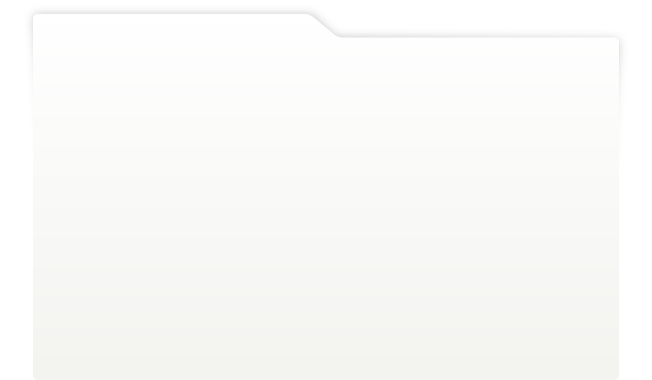
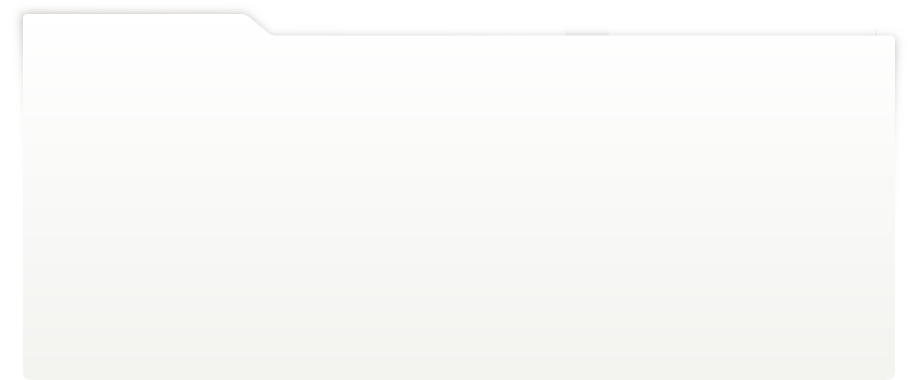
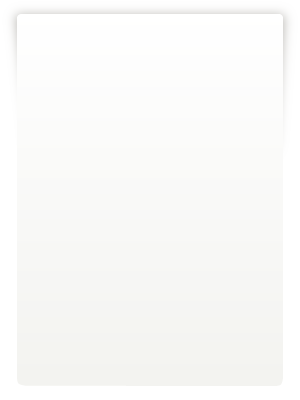
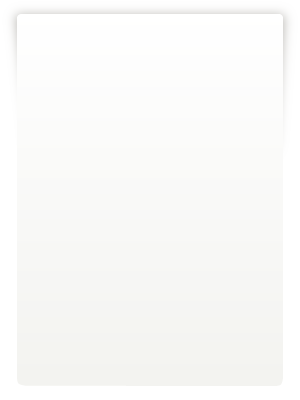
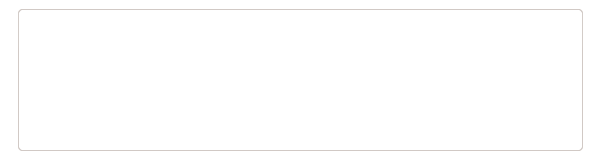
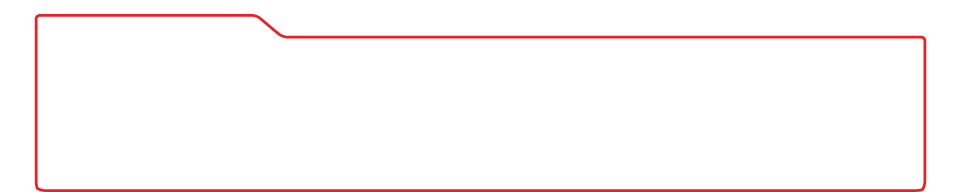
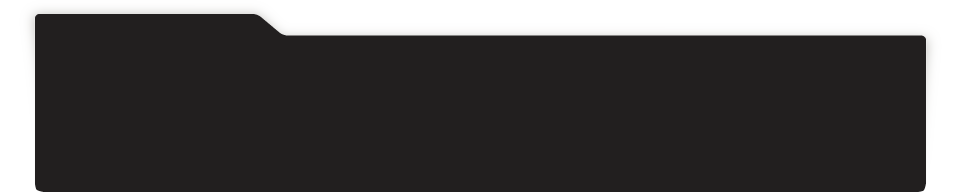
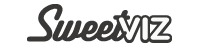
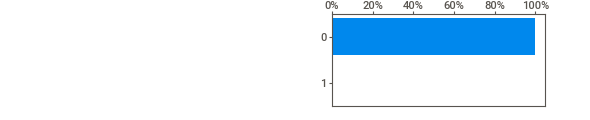
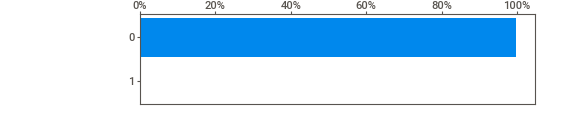
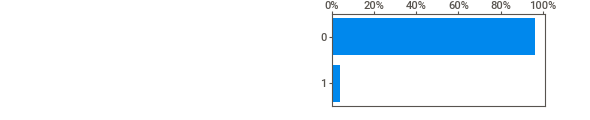
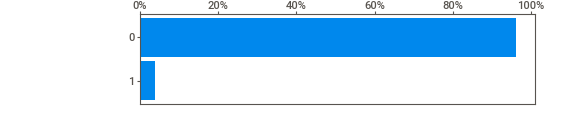
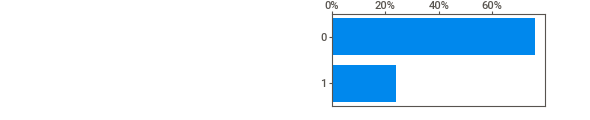
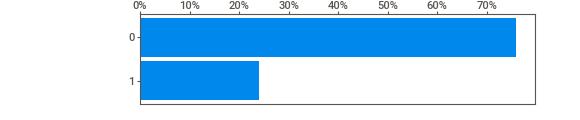
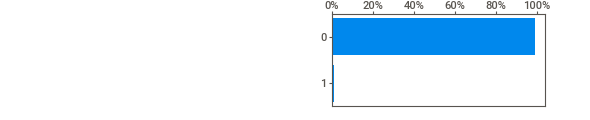
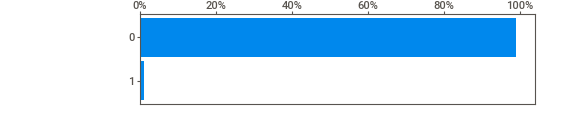
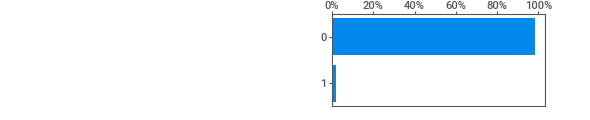
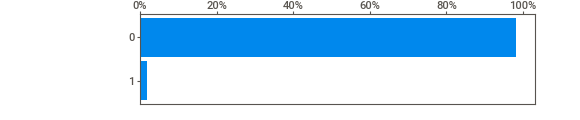
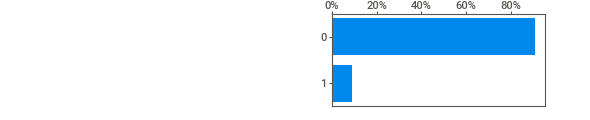
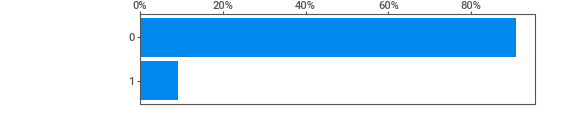
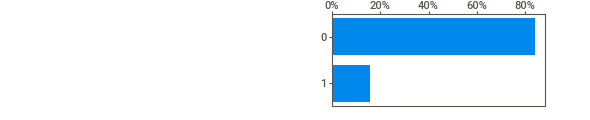
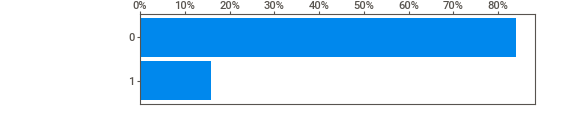
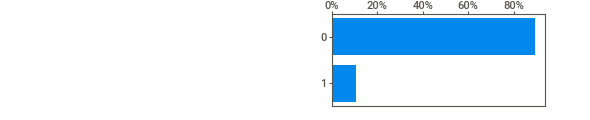
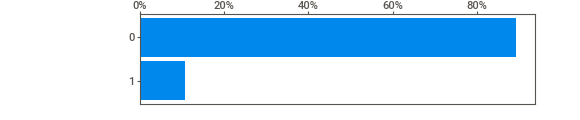
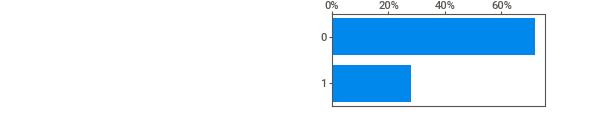
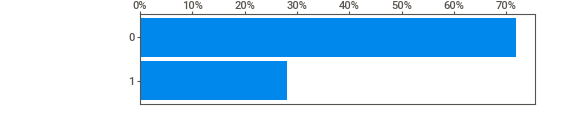
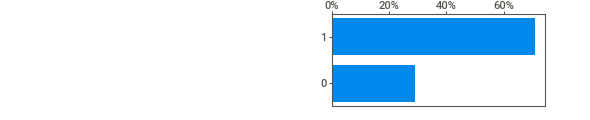
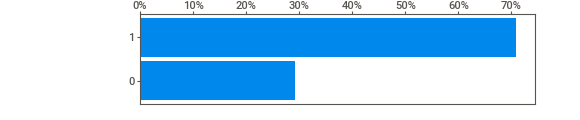
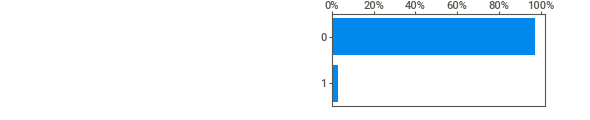
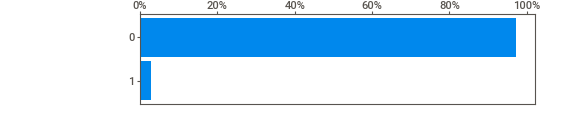
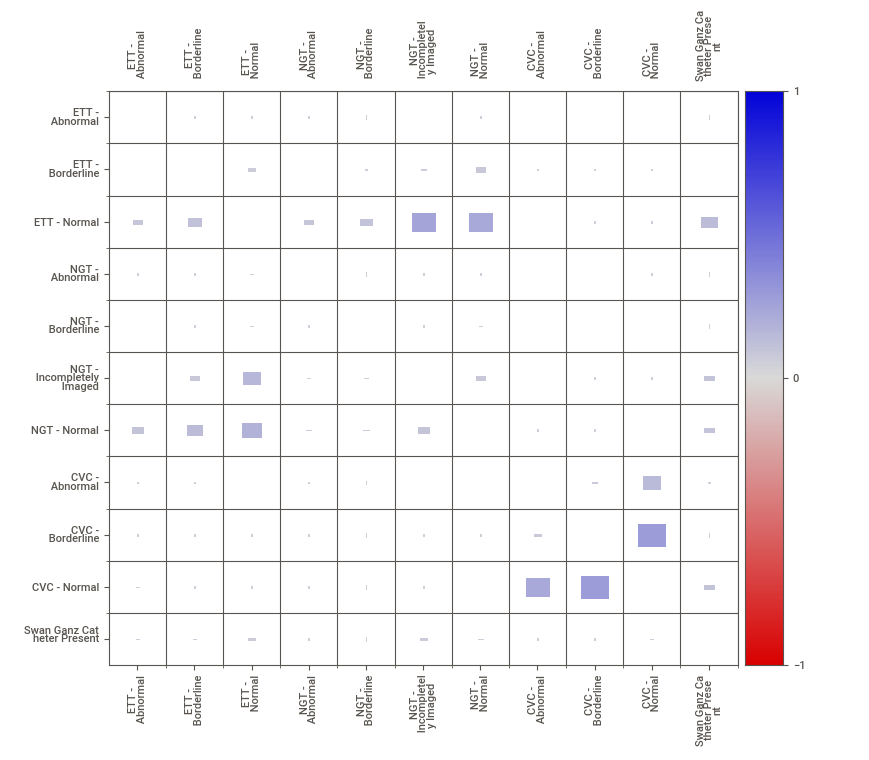
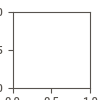

In [103]:
advert_report = sv.analyze(df)
advert_report.show_notebook()

## shared catheter types in the same patient

### aggregating by catheter type

In [172]:
catheter_df = pd.DataFrame(index=df.index, columns=CATHETERS)
labels = df.select_dtypes(int).columns
for catheter in CATHETERS:
    group_cols = [label for label in labels if catheter in label]
    catheter_df[catheter] = df[group_cols].sum(axis=1) 

#### plotting by type

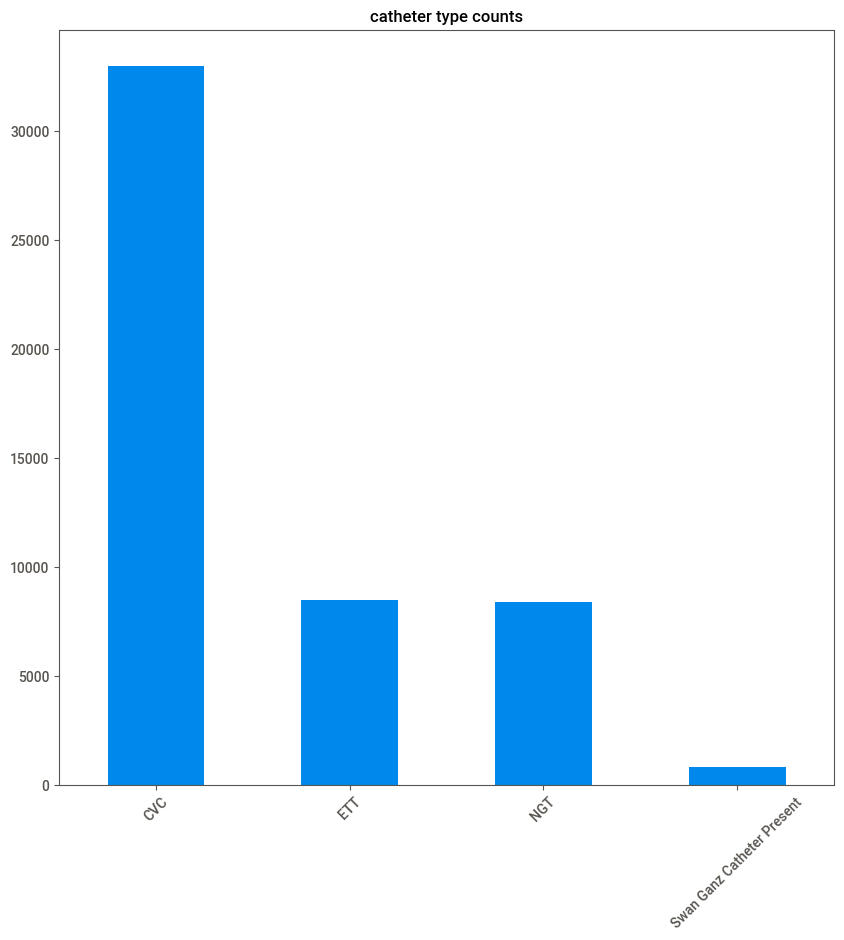

In [173]:
catheter_df.sum().plot(kind='bar', rot=45, figsize=(10,10), fontsize=10, title='catheter type counts')
plt.show()

#### frequency of multi-label records

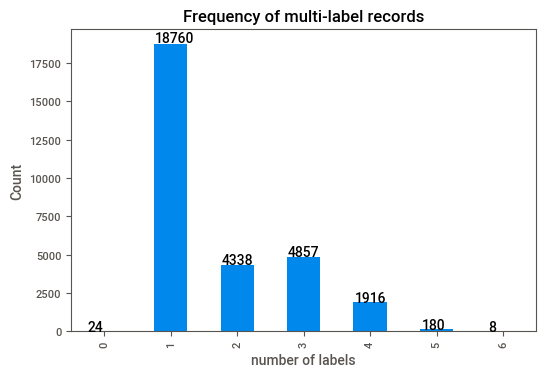

In [174]:
ax = catheter_df.sum(axis=1).value_counts().sort_index().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.xlabel('number of labels')
plt.ylabel('Count')
plt.title('Frequency of multi-label records')
plt.show()

#### binarizing type data frame 

In [175]:
catheter_df_bin = catheter_df.where(catheter_df == 0, 1) # if not 0 convert to 1

#### venn plots - multiple catheter  types in the same patient

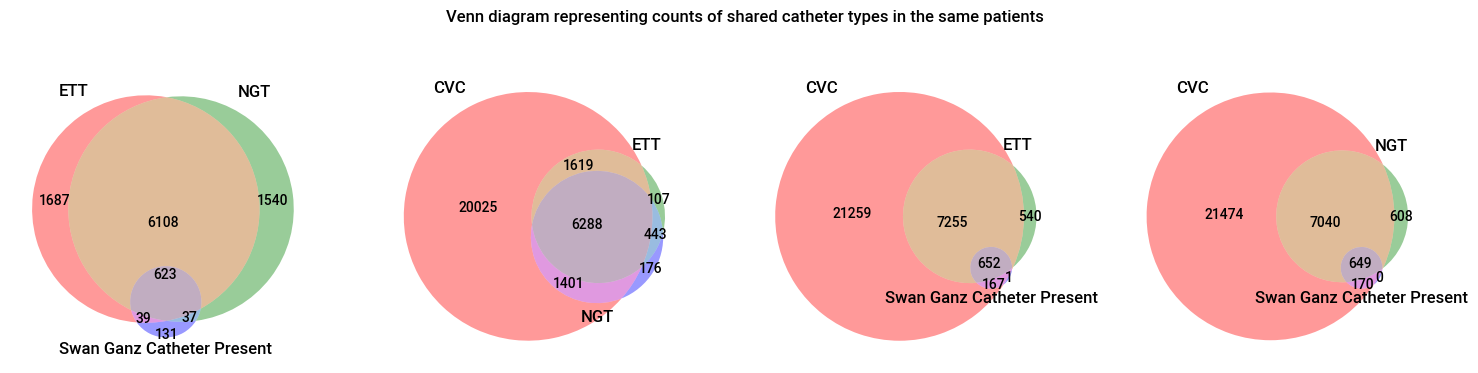

In [181]:
cat_trios = set(list(tuple(sorted(item)) for item in list(permutations(CATHETERS, 3))))
_, axes = plt.subplots(ncols = len(cat_trios), figsize=(15, len(cat_trios)))
for ax, cat_trios in zip(axes, cat_trios):
    group_set = make_sets3(catheter_df_bin, *cat_trios)
    venn3(subsets=group_set, set_labels=cat_trios, ax=ax)
plt.suptitle('Venn diagram representing counts of shared catheter types in the same patients')
plt.tight_layout()
plt.show()

#### plotting some samples

make some lists

In [219]:
cvc = catheter_df_bin['CVC'] == 1
ett = catheter_df_bin['ETT'] == 1
ngt = catheter_df_bin['NGT'] == 1
sg = catheter_df_bin['Swan Ganz Catheter Present'] == 1
only_cvc = cvc & ~ett & ~ngt & ~sg
only_ett = ~cvc & ett & ~ngt & ~sg
only_ngt = ~cvc & ~ett & ngt & ~sg
only_sg = ~cvc & ~ett & ~ngt & sg

cvc_ett_only = cvc & ett & ~ngt & ~sg
cvc_ngt_only = cvc & ~ett & ngt & ~sg
cvc_sg_only = cvc & ~ett & ~ngt & sg
ett_ngt_only = ~cvc & ett & ngt & ~sg
ett_sg_only = ~cvc & ett & ~ngt & sg
ngt_sg_only = ~cvc & ~ett & ngt & sg

cvc_ett_ngt = cvc & ett & ngt & ~sg
cvc_ngt_sg = cvc & ~ett & ngt & sg
cvc_ett_sg = cvc & ett & ~ngt & sg
ett_ngt_sg = ~cvc & ett & ngt & sg

all_types = cvc & ett & ngt & sg

In [203]:
cvc_ett_only

0        False
1        False
2        False
3        False
4        False
         ...  
30078     True
30079    False
30080    False
30081    False
30082     True
Length: 30083, dtype: bool

#### only one type images

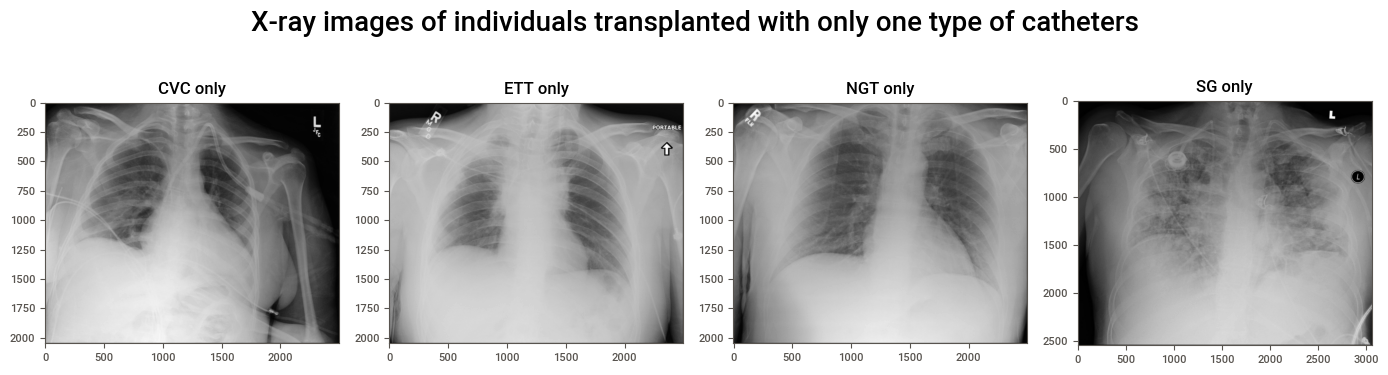

In [199]:
_, axes = plt.subplots(ncols = 4, figsize=(14,4))
get_img(only_cvc, axes[0], df, title='CVC only')
get_img(only_cvc, axes[1], df, title='ETT only')
get_img(only_cvc, axes[2], df, title='NGT only')
get_img(only_cvc, axes[3], df, title='SG only')
plt.suptitle('X-ray images of individuals transplanted with only one type of catheters', fontsize=20)
plt.tight_layout()

#### two types images

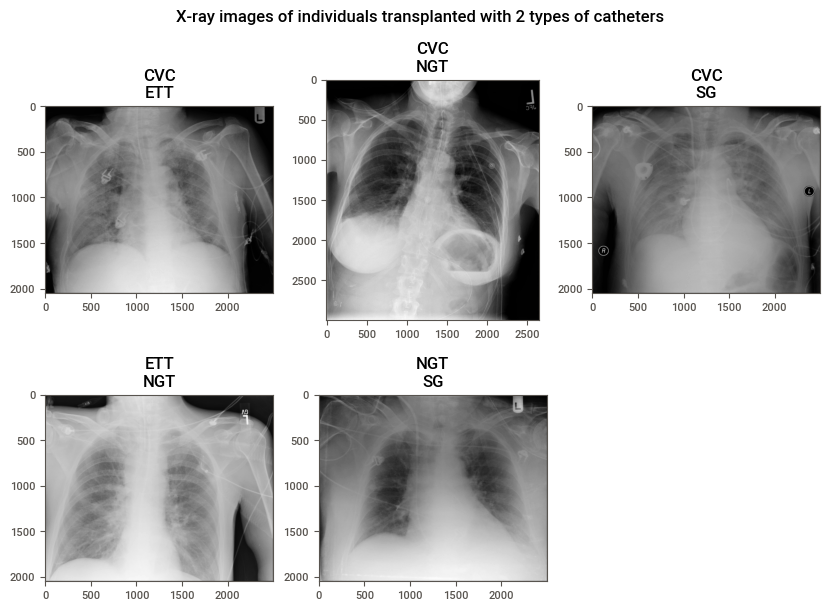

In [217]:
fig=plt.figure(figsize=(10,7))
columns = 3
rows = 2
title_lst = ['CVC\nETT', 'CVC\nNGT', 'CVC\nSG', 'ETT\nNGT', 'NGT\nSG']
cond_lst = [cvc_ett_only, cvc_ngt_only, cvc_sg_only, ett_ngt_only, ngt_sg_only]
a=np.random.rand(2,3)
for i, cond, title in zip(range(1, 6), cond_lst, title_lst):
    ax = fig.add_subplot(rows, columns, i)
    get_img(cond, ax, df, title)
plt.suptitle('X-ray images of individuals transplanted with 2 types of catheters')
plt.show()


#### three type images

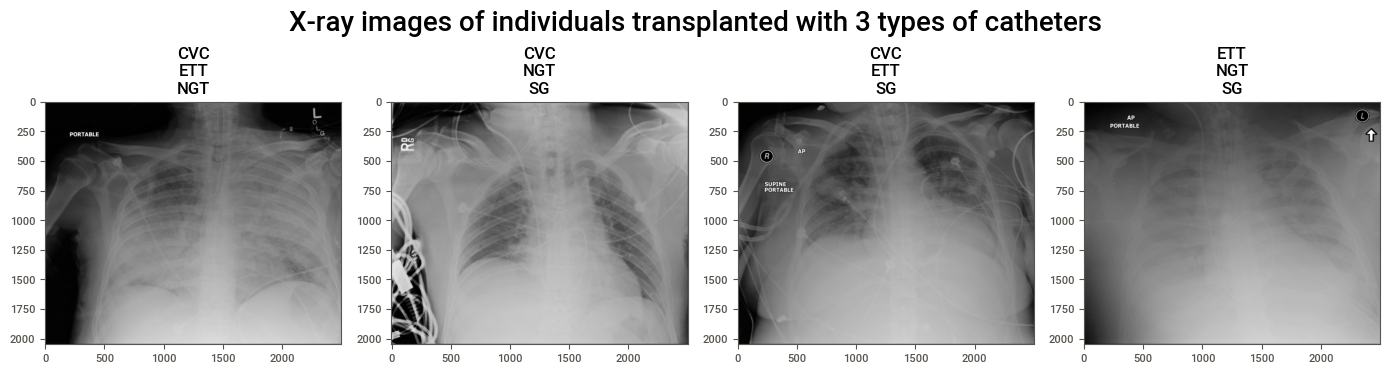

In [221]:
_, axes = plt.subplots(ncols = 4, figsize=(14,4))
get_img(cvc_ett_ngt, axes[0], title='CVC\nETT\nNGT')
get_img(cvc_ngt_sg, axes[1], title='CVC\nNGT\nSG')
get_img(cvc_ett_sg, axes[2], title='CVC\nETT\nSG')
get_img(ett_ngt_sg, axes[3], title='ETT\nNGT\nSG')
plt.suptitle('X-ray images of individuals transplanted with 3 types of catheters', fontsize=20)
plt.tight_layout()

#### all 4 types

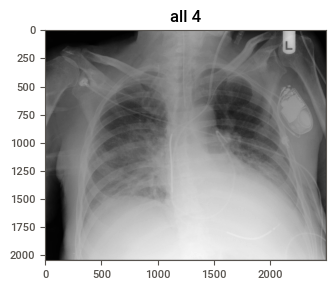

In [222]:
_, axes = plt.subplots(ncols = 1, nrows=1, figsize=(15, len(cat_trios)))
get_img(all_types, axes, df, title='all 4')
plt.tight_layout()
plt.show()

### divide by catheter type

#### helper function

### get cols of each group

In [161]:
cvc_cols = [cvc_col for cvc_col in df.columns if 'CVC' in cvc_col]
ett_cols = [cvc_col for cvc_col in df.columns if 'ETT' in cvc_col]
ngt_cols = [cvc_col for cvc_col in df.columns if 'NGT' in cvc_col]

#### CVC

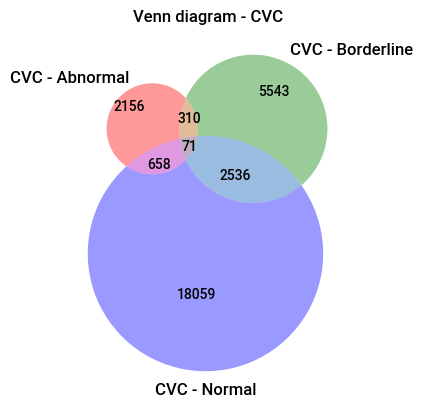

In [162]:
sets = make_sets3(df, *cvc_cols)
venn3(subsets=sets, set_labels=cvc_cols)
plt.tight_layout()
plt.title('Venn diagram - CVC')
plt.show()

#### ETT

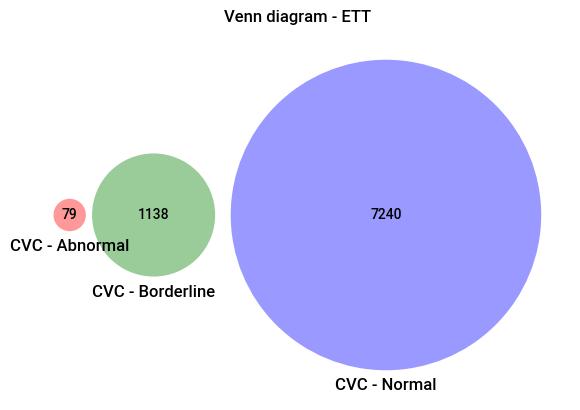

In [223]:
sets = make_sets3(df, *ett_cols)
venn3(subsets=sets, set_labels=cvc_cols)
plt.tight_layout()
plt.title('Venn diagram - ETT')
plt.show()

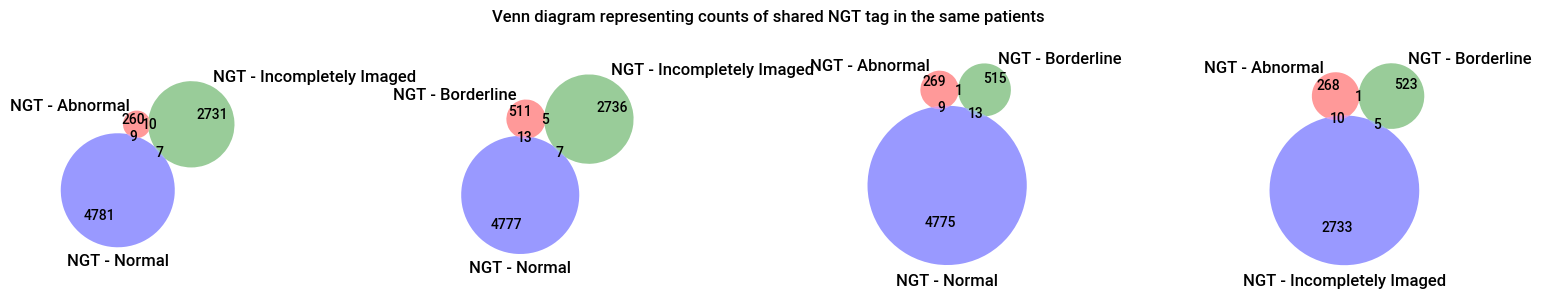

In [227]:
ngt_trios = set(list(tuple(sorted(item)) for item in list(permutations(ngt_cols, 3))))

_, axes = plt.subplots(ncols = len(ngt_trios), figsize=(15, len(cat_trios)))
for ax, trio in zip(axes, ngt_trios):
    sets = make_sets3(df, *trio)
    venn3(subsets=sets, set_labels=trio, ax=ax)
plt.suptitle('Venn diagram representing counts of shared NGT tag in the same patients')
plt.tight_layout()
plt.show()

#### EGT

# EDA over images

## get distribution of size

In [142]:
shape_lst = []
for jpg in Path(TRAIN_IMG_REL_DIR).glob('*jpg'):
    img = cv2.imread(str(jpg), cv2.COLOR_BGR2GRAY)
    shape_lst.append(img.shape)

### general and frequent info

In [171]:
size_df = pd.DataFrame(shape_lst, columns=['height', 'width'])
size_df.describe()

height         width
count  30083.000000  30083.000000
mean    2346.374298   2683.915766
std      349.252643    297.273613
min     1561.000000   1496.000000
25%     2048.000000   2500.000000
50%     2048.000000   2500.000000
75%     2544.000000   3056.000000
max     3567.000000   3827.000000

### height and width distribution

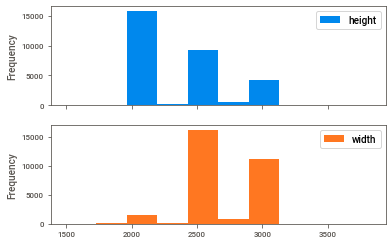

In [172]:
size_df.plot(kind='hist', subplots=True)
plt.show()

In [160]:
print('shortest: {}, longest: {}'.format(sorted(shape_lst)[0], sorted(shape_lst)[-1]))

shortest: (1561, 1702), longest: (3567, 3827)


### preprocessing options

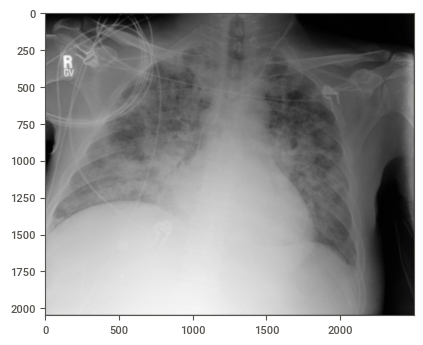

In [12]:
img = cv2.imread(str(np.random.choice(list(Path(TRAIN_IMG_REL_DIR).glob('*jpg')))), cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

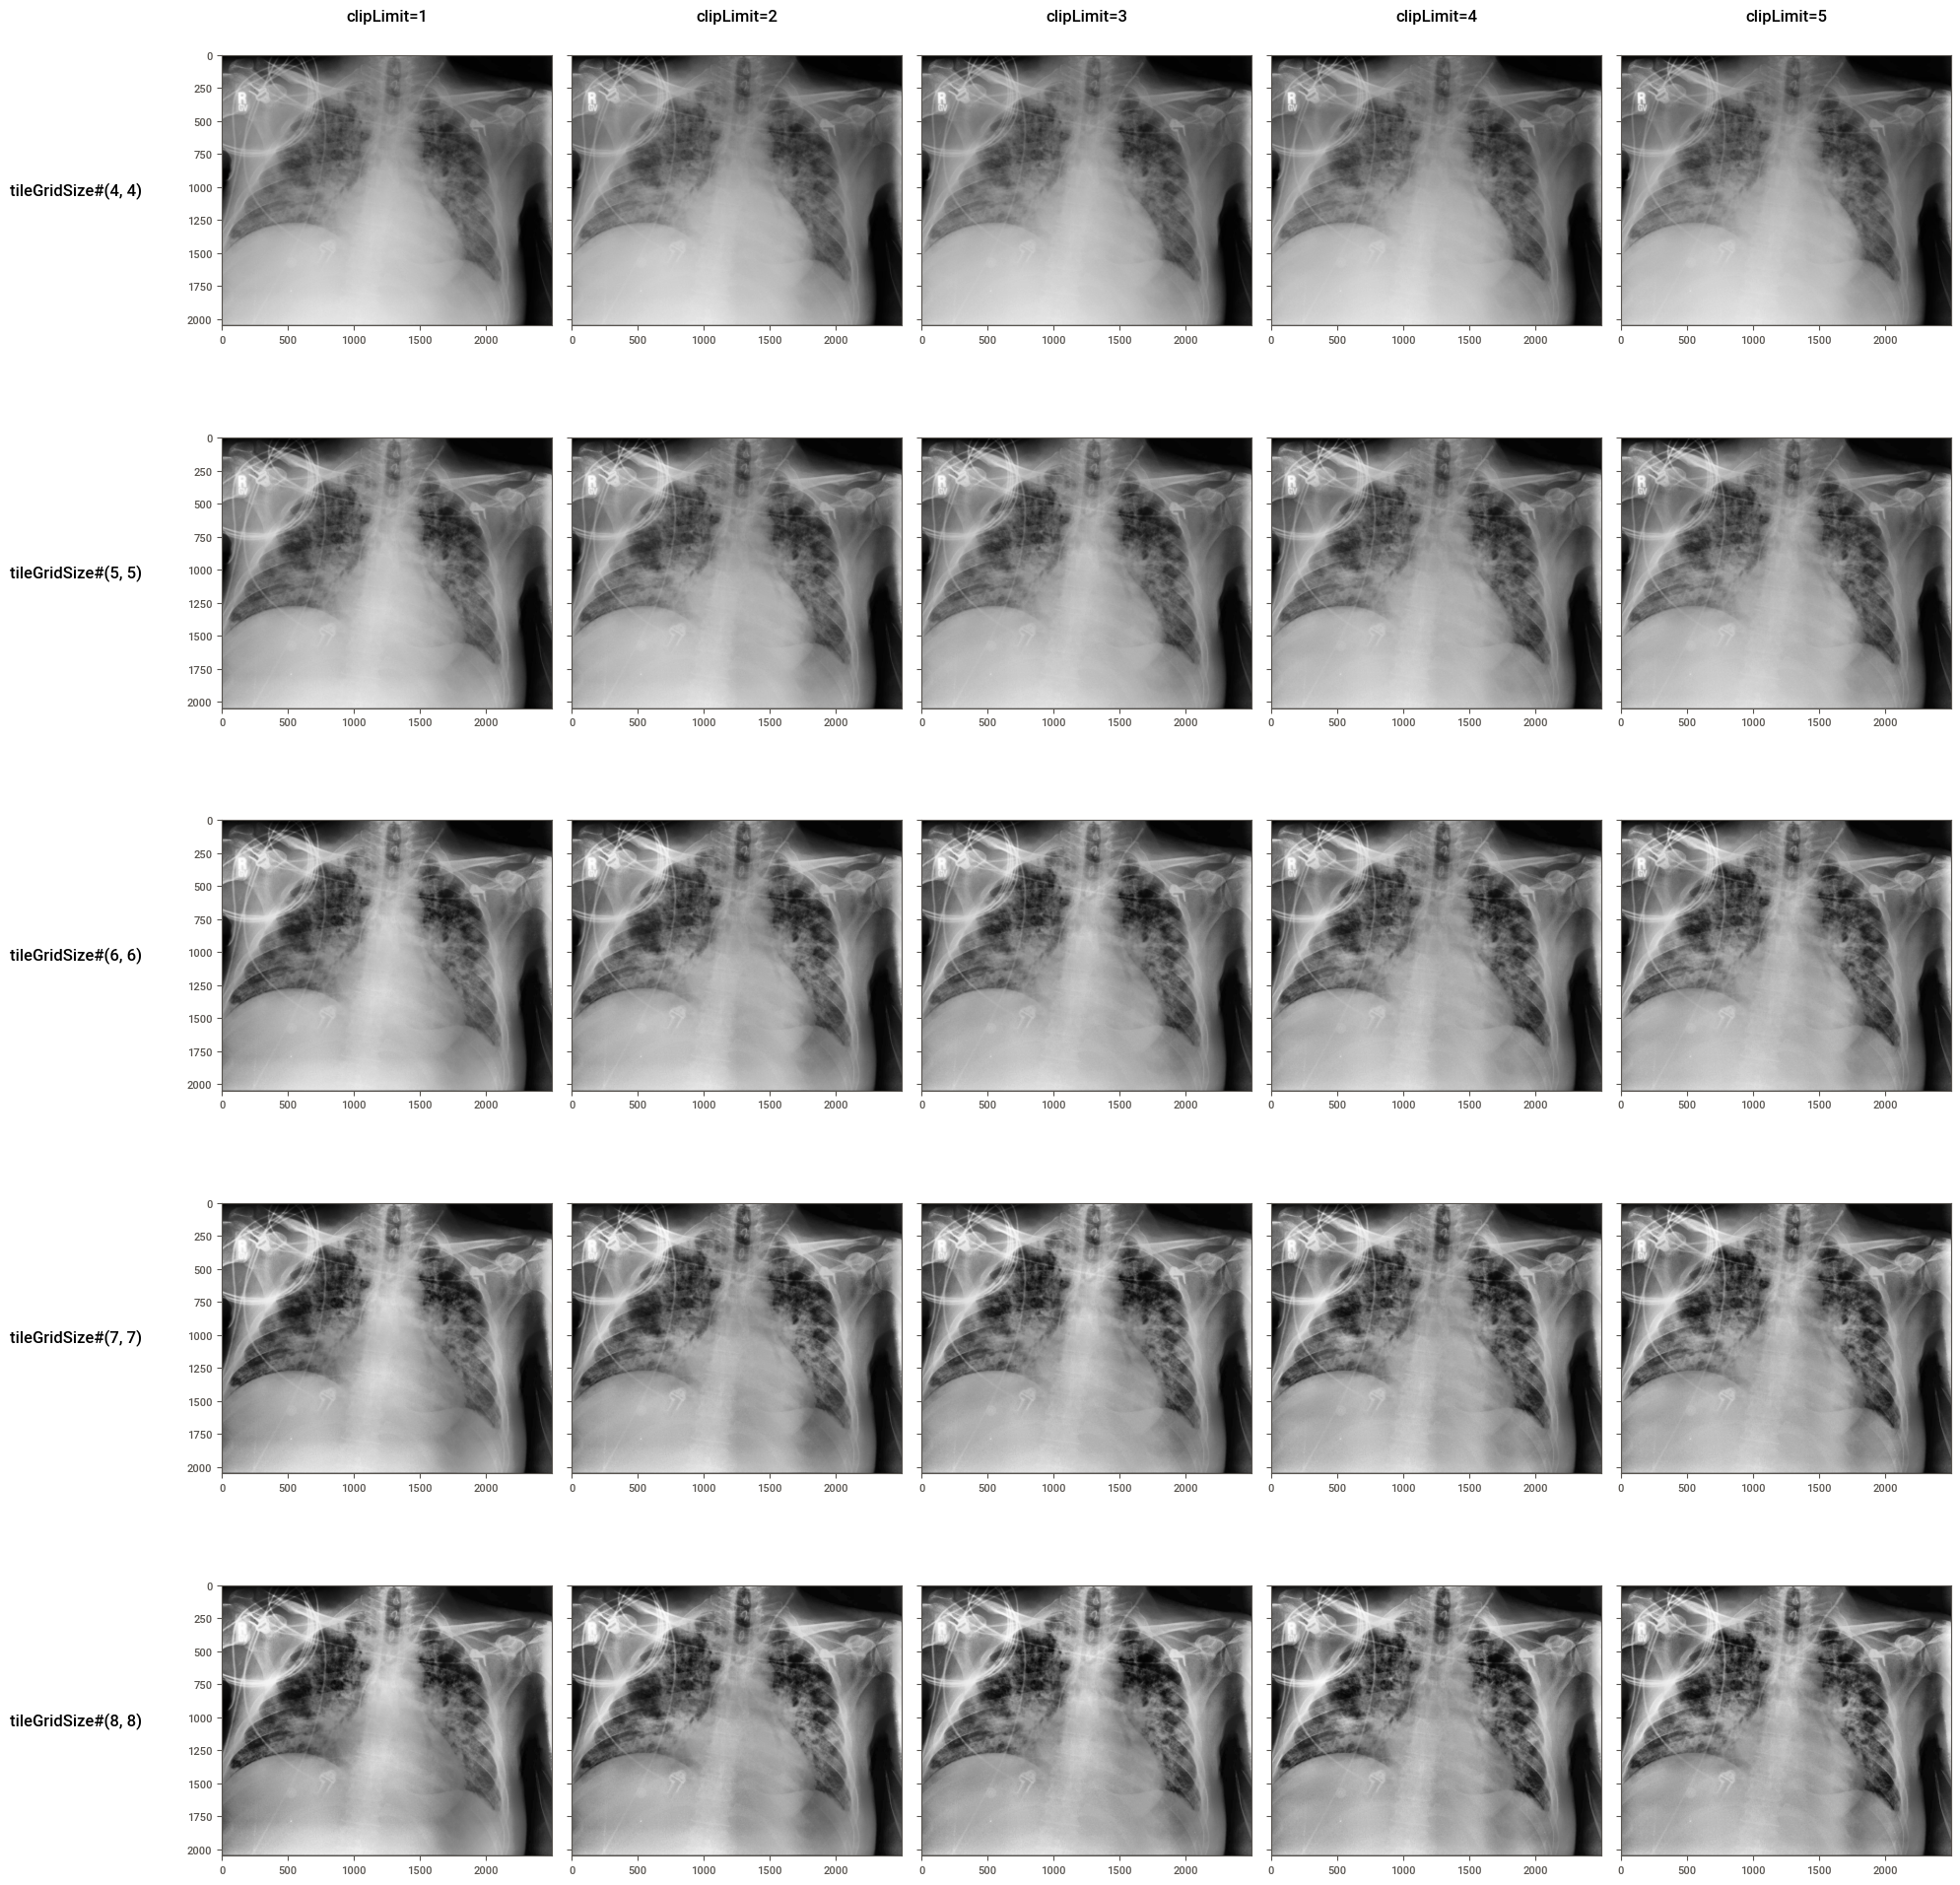

In [13]:
clip_limits = np.arange(1, 6, 1)
tile_grid_sizes = list((size, size) for size in np.arange(4, 9, 1))

_, axes = plt.subplots(nrows=5, ncols=5, figsize=(20,20), sharey=True)

cols = ['clipLimit={}'.format(cl) for cl in clip_limits]
rows = ['tileGridSize#{}'.format(tgs) for tgs in tile_grid_sizes]

for i, clip_limit in enumerate(clip_limits):
    for j, tile_grid_size in enumerate(tile_grid_sizes):
        axes[i,j].imshow(cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size).apply(img), cmap='gray')

pad = len(cols) * len(rows)

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
plt.tight_layout()
plt.show()

## Intensity plot

In [17]:
counter = Counter()
for jpg in Path(TRAIN_IMG_REL_DIR).glob('*jpg'):
    img = cv2.imread(str(jpg), cv2.COLOR_BGR2GRAY)
    counter = counter + Counter(img.ravel().tolist())

In [96]:
pd.DataFrame(counter.items(), columns=['intensity', 'avg_pixel_count']).sort_values(by='intensity')


intensity  avg_pixel_count
0            0       3939716049
1            1       1057141731
86           2       1149117043
85           3       1106110180
84           4       1003170039
..         ...              ...
252        251          9972954
251        252          9933131
255        253         10238662
253        254         10202495
254        255         18581772

[256 rows x 2 columns]

In [97]:
intense_df = pd.DataFrame(counter.items(), columns=['intensity', 'pixel_count']).sort_values(by='intensity')


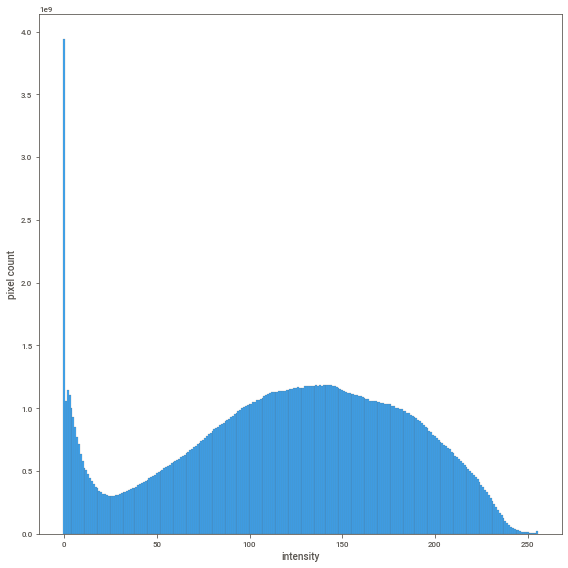

In [98]:
_, ax = plt.subplots(figsize=(8,8))
sns.histplot(x='intensity', weights='pixel_count', data=intense_df, discrete=True)
plt.xlabel('intensity')
plt.ylabel('pixel count')
plt.tight_layout()
plt.show()